# Correction on a disturbed solution

In [3]:
import sys
sys.path.append('../')

In [4]:
from utils import *
config = read_json_file()

method = "fem"
from solver_fem import *
ClassSolver = FEMSolver

geometry = "circle"
from data_square import *
int_a = -0.5
int_b = 1.5

# homogeneous = config["homogeneous"]
homogeneous = 1
S,Sp = (0.5,0.5)
pp = 0.
p = 0.

bash: /home/lecourtier/anaconda3/envs/env_tensorflow/lib/libtinfo.so.6: no version information available (required by bash)
bash: /home/lecourtier/anaconda3/envs/env_tensorflow/lib/libtinfo.so.6: no version information available (required by bash)


In [5]:
import os

# result_dir = "results/"
# if not os.path.exists(result_dir):
#     os.makedirs(result_dir)

# if homogeneous:
#     result_dir += "homogeneous/"
#     if not os.path.exists(result_dir):
#         os.makedirs(result_dir)
# else:
#     result_dir += "non_homogeneous/"
#     if not os.path.exists(result_dir):
#         os.makedirs(result_dir)
# result_dir += method+"_"+geometry+"/"
# if not os.path.exists(result_dir):
#         os.makedirs(result_dir)
# print(result_dir)

result_dir = "results/second_result_pert/"
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

In [6]:
import numpy as np
import pandas as pd
import cv2
import dataframe_image as dfi
from dolfin import *

# noinspection PyUnresolvedReferences
from dolfin import parameters
import matplotlib.pyplot as plt

parameters["ghost_mode"] = "shared_facet"
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["optimize"] = True
parameters["allow_extrapolation"] = True
parameters["form_compiler"]["representation"] = "uflacs"
parameters["form_compiler"]["quadrature_degree"] = 10

## Data

In [7]:
def test_omega():
    mask = omega_mask(64)
    plt.imshow(mask)
    plt.colorbar()
    plt.show()

# test_omega()

In [8]:
def plot_data(F,U):
    mask = omega_mask(100)
    plt.figure(figsize=(9,3))

    plt.subplot(1,2,1)
    plt.imshow(mask * F, origin="lower")
    plt.title("F")
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.imshow(mask * U, origin="lower")
    plt.title("U_ex")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

def test():
    f,fp = (4,1)
    XXYY = get_vert_coord(nb_vert=100)
    F = np.reshape(call_F(np,XXYY,S,f,p),[100,100])
    U = np.reshape(call_Y_true(np,XXYY,S,f,p),[100,100])
    plot_data(F,U)

# test()

## Results

In [13]:
nb_vert = 32
eps = 1e-3
tab_m = [0]+[10**i for i in range(5)]
tab_m_str = ["m = " + str(m) for m in tab_m]

In [14]:
freqs = [1,2,3,4]
fp = 2
params = []
params_pert = []
for f in freqs:
    param = [S,f,p]
    params.append(param)           
    param_pert = [Sp,fp,pp]
    params_pert.append(param_pert)
print("params : ",params)
print("params_pert : ",params_pert)
freqs_str = ["f = " + str(f) for f in freqs]
freqs_str = np.array(freqs_str)

params :  [[0.5, 1, 0.0], [0.5, 2, 0.0], [0.5, 3, 0.0], [0.5, 4, 0.0]]
params_pert :  [[0.5, 2, 0.0], [0.5, 2, 0.0], [0.5, 2, 0.0], [0.5, 2, 0.0]]


In [15]:
solver = ClassSolver(nb_cell=nb_vert-1, params=params, params_pert=params_pert)

In [16]:
def test(eps,tab_m):
    print("eps : ",eps)
    tab_errors = []
    for i in range(len(params)):
        print("# i : ",i)
        tab_error = []
        for m in tab_m:
            print("## m = ",m)
            sol, C_h, norm_L2 = solver.corr_mult(i,eps,m)
            print("||Y_true-Y_true_corr||_L2",norm_L2)
            tab_error.append(norm_L2)
        tab_errors.append(tab_error)
        
    return tab_errors

tab_errors = test(eps,tab_m)
tab_errors = np.array(tab_errors)
np.save(result_dir+"tab_errors_"+method+"_"+geometry+".npy",tab_errors)

# tab_errors = np.load(result_dir+"tab_errors_"+method+"_"+geometry+".npy")

eps :  0.001
# i :  0
## m =  0
Solving linear variational problem.
||Y_true-Y_true_corr||_L2 0.0003327669045357424
## m =  1
Solving linear variational problem.
||Y_true-Y_true_corr||_L2 9.733560708660712e-05
## m =  10
Solving linear variational problem.
||Y_true-Y_true_corr||_L2 6.77318481503643e-05
## m =  100
Solving linear variational problem.
||Y_true-Y_true_corr||_L2 6.585493135179034e-05
## m =  1000
Solving linear variational problem.
||Y_true-Y_true_corr||_L2 6.568714445192572e-05
## m =  10000
Solving linear variational problem.
||Y_true-Y_true_corr||_L2 6.567057711658846e-05
# i :  1
## m =  0
Solving linear variational problem.
||Y_true-Y_true_corr||_L2 0.00016166247480995326
## m =  1
Solving linear variational problem.
||Y_true-Y_true_corr||_L2 0.00023806639874890425
## m =  10
Solving linear variational problem.
||Y_true-Y_true_corr||_L2 6.622383808419661e-05
## m =  100
Solving linear variational problem.
||Y_true-Y_true_corr||_L2 6.56575185280913e-05
## m =  1000
Sol

In [19]:
df_errors = pd.DataFrame(tab_errors,index=freqs_str,columns=tab_m_str)
df_errors

,m = 0,m = 1,m = 10,m = 100,m = 1000,m = 10000
f = 1,0.000333,0.000097,0.000068,0.000066,0.000066,0.000066
f = 2,0.000162,0.000238,0.000066,0.000066,0.000066,0.000066
f = 3,0.000901,0.000158,0.000067,0.000066,0.000066,0.000066
f = 4,0.000965,0.000281,0.000067,0.000066,0.000066,0.000066


In [20]:
img_name = result_dir + "tab_errors_"+method+"_"+geometry+".png"
df_styled = df_errors.style.format("{:.2e}").set_properties(**{'background-color': '#ffffb3'}, subset=tab_m_str[4:])
dfi.export(df_styled,img_name)

image = cv2.imread(img_name)
image[80,:,:] = 0.0
cv2.imwrite(img_name,image)

True

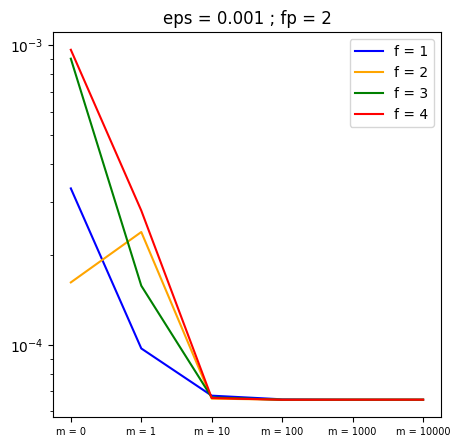

In [21]:
plt.figure(figsize=(5,5))

tab_colors=["blue","orange","green","red"]
for (i,freq_str) in enumerate(freqs_str):
    plt.semilogy(tab_errors[i],tab_colors[i],label=freq_str)

plt.title("eps = "+str(eps)+" ; fp = "+str(fp))
plt.xticks(np.arange(0,len(tab_m),1),tab_m_str, fontsize=7)
plt.legend()
plt.savefig(result_dir+"fig_"+method+"_"+geometry+".png")
plt.show()